# Analysis

![image.png](main.png)

In [28]:
import numpy as np
import pandas as pd
import cairocffi
import itertools
import string

In this workbook, I will read the data files created from using the Spotify API and build a network of genres from their co-ocurrence matrix. Whenever 2 genres are tagged for the same artist, they will be added as an edge to the network, additionally the network will be weighted by the count of times 2 genres are tagged together

In [7]:
#Reading in artists data and removing artists without any genres tagged
artists = pd.read_csv('artists_nodes_gephi.csv')
artists = artists.loc[artists['genres'] != '[]']
len(artists)

87709

In [8]:
artists.sample(5)

,followers,genres,spotify id,Label,popularity,uri,strgnrs
116550,6205,['gospel r&b'],2VNVer52cmYJdBox2e8N6t,Debra Killings,10,spotify:artist:2VNVer52cmYJdBox2e8N6t,gospel r&b
128210,80413,"['hip hop tuga', 'trap tuga']",2DEfqyWjAMIfKYMXb1V8L1,Nenny,41,spotify:artist:2DEfqyWjAMIfKYMXb1V8L1,hip hop tuga_trap tuga
75928,30740,['korean pop'],4Kw6Puq72YDjXvVBrBkdw3,Ha Yea Song,38,spotify:artist:4Kw6Puq72YDjXvVBrBkdw3,korean pop
118229,17025,"['christian hip hop', 'christian trap']",0Y2tgcJdamwlQDZ6HwecWb,Alex Faith,19,spotify:artist:0Y2tgcJdamwlQDZ6HwecWb,christian hip hop_christian trap
144243,3609,['dmv rap'],7iJYwPCkyVoZCINa8YtvtI,Lil Xelly,30,spotify:artist:7iJYwPCkyVoZCINa8YtvtI,dmv rap


As you can see, the genres column is a list of tags for each artist. To build a network from this column I will first, separate the tag and count all unique genres and every combination of genres that occur in the dataset. From this list of nodes and edges, I will have a weghted network

In [10]:
gnrs = []
for i in artists.index:
    tmpdict = {'genre': artists['strgnrs'][i].split("_"),'popularity': artists['popularity'][i],
              'followers': artists['followers'][i]}
    gnrs.append(tmpdict)
c = [{'genres': list(itertools.combinations(i['genre'],2)), 'popularity': i['popularity'], 'followers': i['followers']} for i in gnrs]


In [11]:
#Creating a list of edges from the combinations created above
edges = [{'edge': j, 'population': i['popularity'],'followers': i['followers']}  for i in c for j in i['genres']]
edges = pd.DataFrame.from_dict(edges)
edges = pd.DataFrame(edges.groupby(['edge']).agg(['mean','count']))
edges.columns = ['mean popularity','count','mean followers', 'all count']
edges = edges.reset_index()
edges = edges[['edge','mean popularity','count','mean followers']]


In [12]:
nodes = [{'node': j, 'population': i['popularity'],'followers': i['followers']}  for i in gnrs for j in i['genre']]
nodes = pd.DataFrame.from_dict(nodes)
nodes = pd.DataFrame(nodes.groupby(['node']).agg(['mean','count']))
nodes.columns = ['mean popularity','count','mean followers', 'all count']
nodes = nodes.reset_index()
nodes = nodes[['node','mean popularity','count','mean followers']]
# nodes = nodes[72:].reset_index(drop = True)

In [13]:
# Create graph
g = Graph()
g.add_vertices(nodes['node'])
g.add_edges(edges['edge'])
g.es['weight'] = edges['count']
g.es['popularity'] = edges['mean popularity']
g.es['followers'] = edges['mean followers']
g.vs['weight'] = nodes['count']
g.vs['popularity'] = nodes['mean popularity']
g.vs['followers'] = nodes['mean followers']
g.to_undirected()

## Understanding the Network

The network now has 5443 vertices and a pretty low density. Lower densities are typical as the network gets bigger.

In [14]:
print("Number of vertices:", g.vcount())
print("Number of edges:", g.ecount())
print("Density of the graph:", 2*g.ecount()/(g.vcount()*(g.vcount()-1)))

Number of vertices: 5443
Number of edges: 42518
Density of the graph: 0.0028708199229960183


Below we can see that the average degree is 23.91, while the max degree is pretty high. The top 10 vertices by degree are shown below. "Art Pop" seems to be the most connected genre. This would make more sense obnce you see the network, as it makes sense that a ambiguous, experimental genre like Art Pop would be associated with a wide variety of genres. The weighted degree which takes into account the edge weights shows a slightly different picture, we see that Rock seems to have the highest weighted degree. This is the metric we will use in our graph visualization.

In [15]:
degrees = []
total = 0
nodelength = len(nodes)

for n in range(nodelength):
    neighbours = g.neighbors(n, mode='ALL')
    total += len(neighbours)
    degrees.append(len(neighbours))
    
print("Average degree:", total/nodelength)
print("Maximum degree:", max(degrees))
print("Vertex ID with the maximum degree:", degrees.index(max(degrees)))

Average degree: 15.623002020944332
Maximum degree: 188
Vertex ID with the maximum degree: 2405


In [16]:
degreever = sorted(zip(g.degree(),g.vs), reverse = True)
for i in degreever[:10]:
    print("Vertex: "+i[1]['name']+", Degree: "+str(i[0]))

Vertex: indietronica, Degree: 188
Vertex: art pop, Degree: 185
Vertex: rock, Degree: 179
Vertex: metal, Degree: 176
Vertex: alternative rock, Degree: 176
Vertex: indie rock, Degree: 174
Vertex: chamber pop, Degree: 169
Vertex: singer-songwriter, Degree: 166
Vertex: noise pop, Degree: 164
Vertex: post-metal, Degree: 162


In [17]:
weights = sorted(zip(g.strength(weights=g.es["weight"]),g.vs), reverse = True)
for i in weights[:10]:
    print("Vertex: "+i[1]['name']+", Weighted Degree: "+str(i[0]))

Vertex: rock, Weighted Degree: 1474.0
Vertex: classic rock, Weighted Degree: 1453.0
Vertex: singer-songwriter, Weighted Degree: 1360.0
Vertex: album rock, Weighted Degree: 1315.0
Vertex: soft rock, Weighted Degree: 1286.0
Vertex: mellow gold, Weighted Degree: 1243.0
Vertex: hard rock, Weighted Degree: 1204.0
Vertex: country rock, Weighted Degree: 1034.0
Vertex: metal, Weighted Degree: 998.0
Vertex: electro house, Weighted Degree: 997.0


The distribution of degree is heavily right-skewed which is typical of real-world networks. The curve could also be close to a power-law distribution with alpha between 2 and 3, in which case it would be a Scale-Free network, I tried using the Kolmogorov-Smirnoff test to check if the data fit a power law distribution, but the hypothesis was rejected, so this isn't really a scale-free network

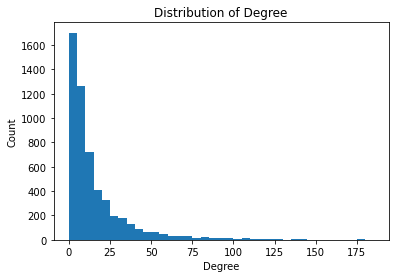

In [18]:
import matplotlib.pyplot as plt
plt.hist(g.degree(),bins = range(0,max(g.degree()),5))
plt.title("Distribution of Degree")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

In [19]:
result = power_law_fit(g.degree())
print(result.summary())

Fitted power-law distribution on discrete data

Exponent (alpha)  = 2.890287
Cutoff (xmin)     = 30.000000

Log-likelihood    = -3494.375553

H0: data was drawn from the fitted distribution

KS test statistic = 0.058566
p-value           = 0.000000

H0 rejected at significance level 0.05


Betweenness Centrality and Page Rank are 2 other measures that help us understand which nodes are most important for the flow of information. Betweenness Centrality is based on Shortest Paths from the node to all the other nodes and PageRank was the first algortihm used in google and was invented by its founders. It basically gives a probability distribution that details the likelood of landing at a given node (or genre, or webpage) when a person randomly clicks on nodes linked to their current node. 

In [20]:
betweenness = sorted(zip(g.betweenness(directed = False, weights=g.es["weight"]),g.vs), reverse = True)
for i in betweenness[:10]:
    print("Vertex: "+i[1]['name']+", Betweenness: "+str(i[0]))

Vertex: downtempo, Betweenness: 408313.94172896835
Vertex: latin alternative, Betweenness: 362312.4317116179
Vertex: pop, Betweenness: 325762.49155542685
Vertex: world, Betweenness: 289266.14175551507
Vertex: indietronica, Betweenness: 285967.47664904565
Vertex: laboratorio, Betweenness: 282556.2355543548
Vertex: conscious hip hop, Betweenness: 239710.94931203555
Vertex: alternative r&b, Betweenness: 239609.9670760477
Vertex: compositional ambient, Betweenness: 237691.93496925494
Vertex: metropopolis, Betweenness: 234385.05815207065


In [21]:
pgrnk = sorted(zip(g.pagerank(directed = False, weights=g.es["weight"]),g.vs), reverse = True)
for i in pgrnk[:10]:
    print("Vertex: "+i[1]['name']+", Page Rank: "+str(i[0]))

Vertex: classical performance, Page Rank: 0.0016797909415255834
Vertex: indietronica, Page Rank: 0.0013784436219411716
Vertex: latin alternative, Page Rank: 0.0013697574893111574
Vertex: art pop, Page Rank: 0.0013347305433534407
Vertex: afropop, Page Rank: 0.0012343998231619576
Vertex: electronica, Page Rank: 0.0012124585918531906
Vertex: chamber pop, Page Rank: 0.0012072158938527915
Vertex: indie rock, Page Rank: 0.0012013731077348173
Vertex: rock, Page Rank: 0.001174278914966116
Vertex: alternative rock, Page Rank: 0.001161136066941991


## Community Detection

In this section, I have tried to run multiple community detection models and compared them against each other. I am not going to go into detail into the algorithms, but one thing to know is modularity which is a measure used to understand how well the communities are strucured. Since this is usupervised learning, we can't have one measure that gives us an exact understanding of close to the truth the algorithm is, however, modularity is a close estimator of tight our communities are. 

$$Q = \sum_{i = 1}^{k}{(e_{ii}-a_{i}^2)}$$
where $e_{ii}$ is the probability that an edge would fall in module i and $a_{i}^2$ is the probabilty that a random edge would into a module i. Hence, networks with high modularity wouuld mean that there are dense connections between the nodes within modules but sparse connections between nodes in different modules. Modularity isn't perfect, however, it suffers a resolution limit (when there are communities within communities). 

In [22]:
models = {}
leiden1 = g.community_leiden(objective_function = 'modularity')
models["leiden1"] = leiden1
leiden2 = g.community_leiden(objective_function = 'CPM',weights=g.es["weight"])
models["leiden2"] = leiden2
wtrap = g.community_walktrap(weights=g.es["weight"])
clust=wtrap.as_clustering()
models["clust"] = clust
infomap = g.community_infomap(edge_weights=g.es["weight"], vertex_weights = g.vs['weight'])
models["infomap"] = infomap
labelprop = g.community_label_propagation(weights=g.es["weight"])
models["labelprop"] = labelprop
multilevel = g.community_multilevel(weights=g.es["weight"])
models["multilevel"] = multilevel

We can see that the Multilevel Algorithm gives the highest modularity. Multilevel Algorithm maximises the modularity of the network by considered a complete network with the same ertices and solving for a minimum cut problem, Multilevel Modularity also trie to solve for the resolution problem by providing different levels of cuts. I have also tried to compare the different community structures obtained by calculating the NMI (Normalised Mutual Information) of each of the community structures obtained, NMI of 1 means the structues are the exact same and nmi of 0 means they are completely different, since all the structues have nmi of over 0.5, we can possibly say that there is an underlying (if loose) structure and that our modularity isn't high through chance.

In [23]:
for mod in models.items():
    print("Modularity by "+ mod[0]+": "+str(mod[1].modularity))
    print("Number of clusters according to "+mod[0]+": "+str(len(mod[1])))

Modularity by leiden1: 0.6653764307150423
Number of clusters according to leiden1: 326
Modularity by leiden2: 0.573788186194145
Number of clusters according to leiden2: 2788
Modularity by clust: 0.7049155437262749
Number of clusters according to clust: 944
Modularity by infomap: 0.7066805862273645
Number of clusters according to infomap: 585
Modularity by labelprop: 0.6765687931976676
Number of clusters according to labelprop: 630
Modularity by multilevel: 0.7769920422051722
Number of clusters according to multilevel: 342
